# [Νικόλαος Μανιάτης](mailto:nikolaosmaniatis@mail.ntua.gr)
# Α.Μ.: 03400097 

<h1><b>Ο Αλγόριθμος <i>Metropolis-Hastings</i></b></h1>

<b>Σημείωση</b>: Η άσκηση αυτή έχει βασιστεί στο άρθρο που μπορεί να βρεθεί <a href="https://www.tweag.io/blog/2019-10-25-mcmc-intro1/">εδώ</a>. Στο συγκεκριμένο άρθρο μπορεί να βρεθεί μια πιο αναλυτική εισαγωγή στις μεθόδους <b><i>Monte Carlo Markov Chain</i> (<i>MCMC</i>)</b> και στον αλγόριθμο <b><i>Metropolis-Hastings</i></b>, καθώς και συνοδευτικά άρθρα για πιο προχωρημένα ζητήματα.


Στην άσκηση αυτή θα μελετήσετε τον αλγόριθμο <b><i>Metropolis-Hastings</i></b>. Συγκεκριμένα, θα χρησιμοποιήσετε τον αλγόριθμο για να λάβετε δειγματικά στοιχεία (sampling points) από μία <b><i>τυπική κανονική κατανομή</i> (<i>standard normal distribution</i>)</b>, δηλαδή μία κανονική κατανομή συνεχούς τυχαίας μεταβλητής με μέση τιμή $μ=0$ και τυπική απόκλιση $σ=1$. 

Ως <b><i>proposal conditional density</i></b> θα λάβετε μία ομοιόμορφη κατανομή στο διάστημα $(-\frac{Δ}{2}, \frac{Δ}{2})$. Αφού η <b><i>proposal conditional density</i></b> που θα χρησιμοποιήσετε είναι μία συμμετρική κατανομή, ο αλγόριθμος <b><i>Metropolis-Hastings</i></b> θα λάβει την απλοποιημένη μορφή του, δηλαδή η πιθανότητα να πραγματοποιήσετε μία μετάβαση από την κατάσταση $x_{old}$ στην κατάσταση $x_{new}$ για μια κατανομή $π$ θα δίνεται από τον παρακάτω τύπο:

$$
p_{accept}(x_{new} | x_{old}) = min\left[1, \frac{π(x_{new})}{π(x_{old})}\right]
$$

Αναλυτικές οδηγίες σχετικά με το πώς προκύπτει ο παραπάνω τύπος περιλαμβάνονται στις διαφάνειες του μαθήματος, αλλά και στο άρθρο πάνω στο οποίο βασίστηκε η συγκεκριμένη άσκηση.

<h3><b>Υλοποίηση του Αλγορίθμου <i>Metropolis-Hastings</i> σε Python</b></h3>

Αρχικά, θα ορίσουμε τη μέθοδο <b><i>log_prob</i></b>, η οποία θα χρησιμοποιηθεί για τον υπολογισμό τιμών από την <b><i>τυπική κανονική κατανομή</i></b>. Να σημειωθεί ότι λαμβάνεται ο λογάριθμος της κατανομής αυτής. Ο λογάριθμος αυτός μπορεί να υπολογιστεί εύκολα από τον τύπο της <b><i>τυπικής κανονικής κατανομής</i></b>, που είναι διαθέσιμος από <a href="https://en.wikipedia.org/wiki/Normal_distribution#Standard_normal_distribution">εδώ</a>. Λόγοι για τους οποίους προτιμάται αυτή η μορφή μπορούν να αναζητηθούν <a href="https://stats.stackexchange.com/questions/137710/metropolis-hastings-using-log-of-the-density">εδώ</a>. Τέλος, οι σταθερές μπορούν να αγνοηθούν από τον τύπο με ασφάλεια λόγω της μορφή του αλγορίθμου <b><i>Metropolis-Hastings</i></b>.

 > Παραθέτω τις πράξεις για καλύτερη κατανόηση:
Η κανονική κατανομή δίνεται από την σχέση: 
$$\varphi(x) = \frac{e^{-\frac{x^2}{2}}}{\sqrt{2\pi}}$$
όπου παίρνοντας τον λογάριθμο της και εφαρμόζοντας ιδιότητες λογαρίθμων:
$$ \log(\varphi(x))  = -\frac{1}{2}(x^2 + \log(2\pi) ) $$
άρα, όπως αναφέρθηκε, αγνοούμε τις σταθερές καθώς για τον αλγόριθμο Metropolis-Hastings δεν είναι απαραίτητο να ξέρουμε την συνάρτηση κανονικοποίησης της κατανομής που θέλουμε να δειγματοληπτήσουμε.  

In [1]:
def log_prob(x):
     return -0.5 * np.float64(x ** 2)

Στη συνέχεια, ορίζουμε τη μέθοδο <b><i>proposal</i></b>, η οποία θα χρησιμοποιηθεί για τον υπολογισμό τιμών από την ομοιόμορφη κατανομή, η οποία αποτελεί την <b><i>proposal conditional density</i></b>.

In [2]:
def proposal(x, stepsize):
    return np.random.uniform(low=x - 0.5 * stepsize, 
                             high=x + 0.5 * stepsize, 
                             size=x.shape)

Η πιθανότητα αποδοχής μιας νέας κατάστασης $x_{new}$ δεδομένης της τρέχουσας κατάστασης $x_{old}$ υπολογίζεται από τη παρακάτω μέθοδο. Να σημειωθεί πως στη συγκεκριμένη μέθοδο, ο τύπος $p_{accept}$ που δόθηκε παραπάνω έχει τροποποιηθεί κατάλληλα, ώστε να μην εμφανίζονται αρνητικές τιμές. Οι δύο μορφές του τύπου είναι ισοδύναμες, καθώς σημασία έχει η σύγκριση δύο τιμών και όχι οι ακριβείς τιμές, όπως φαίνεται από τον παραπάνω τύπο.

In [3]:
def p_acc_MH(x_new, x_old, log_prob):
    return min(1, np.exp(log_prob(x_new) - log_prob(x_old)))

Στη συνέχεια, υλοποιείται η μέθοδος με την οποία θα αποφασίζει ο αλγόριθμος <b><i>Metropolis-Hastings</i></b> εάν θα γίνει δεκτό ένα προτεινόμενο βήμα.

In [4]:
import numpy as np
def sample_MH(x_old, log_prob, stepsize):
    x_new = proposal(x_old, stepsize)
    accept = np.random.random() < p_acc_MH(x_new, x_old, log_prob)
    if accept:
        return accept, x_new
    else:
        return accept, x_old

Τέλος, ορίζεται μία συνάρτηση που μετράει πόσες φορές έγιναν αποδεκτά τα προτεινόμενα βήματα.

In [5]:
def build_MH_chain(init, stepsize, n_total, log_prob):

    n_accepted = 0
    chain = [init]

    for _ in range(n_total):
        accept, state = sample_MH(chain[-1], log_prob, stepsize)
        chain.append(state)
        n_accepted += accept
    
    acceptance_rate = n_accepted / float(n_total)
    
    return chain, acceptance_rate

<h3><b>Ερωτήματα (Μέρος Α)</b></h3>

<ul>
<li>Με ποιον τρόπο αποφασίζει ο αλγόριθμος <b><i>Metropolis-Hastings</i></b> εάν θα γίνει δεκτό ένα προτεινόμενο βήμα; Να εξηγήσετε συνοπτικά βάσει των παραπάνω μεθόδων.</li>
<li>Με ποιον τρόπο αξιοποιούνται οι <b><i>αλυσίδες Markov</i> (<i>Markov Chains</i>)</b> από τον αλγόριθμο <b><i>Metropolis-Hastings</i></b> για τη λήψη τυχαίων δειγματικών σημείων από μία κατανομή πιθανοτήτων;</li>
<li>Ο αλγόριθμος <b><i>Metropolis-Hastings</i></b> χρησιμοποιείται για τη λήψη τυχαίου δείγματος από μία κατανομή πιθανοτήτων για την οποία είναι αδύνατο να λάβουμε τέτοια δειγματικά στοιχεία λόγω αδυναμίας πλήρους καταγραφής του δειγματικού χώρου ή/και υπολογισμού κάποιας <b><i>σταθεράς κανονικοποίησης</i></b> που εμφανίζεται στην κατανομή. Έτσι, λαμβάνεται ως <b><i>κατανομή στόχος</i></b> μία κατανομή που έχει γνωστή μορφή, ανάλογη με την κατανομή από την οποία θέλουμε να λάβουμε τα δειγματικά στοιχεία. Με ποιον τρόπο καταφέρνει ο αλγόριθμος <b><i>Metropolis-Hastings</i></b> να δώσει αποτελέσματα παρά το γεγονός ότι αγνοεί τη <b><i>σταθερά κανονικοποίησης</i></b>;
</ul>

----------------------------------

 - > Με ποιον τρόπο αποφασίζει ο αλγόριθμος Metropolis-Hastings εάν θα γίνει δεκτό ένα προτεινόμενο βήμα; Να εξηγήσετε συνοπτικά βάσει των παραπάνω μεθόδων.
 
Έστω ότι βρισκόμαστε στην κατάσταση $x_{t}$. Ο αλγόριθμος επιλέγει έναν τυχαίο δείγμα $x_{new}$ από την proposed κατανομή, στην περίπτωσή μας την ομοιόμορφη στο $[-\frac{\Delta}{2},+\frac{\Delta}{2}]$. Για να γίνει δεκτό ένα προτεινόμενο βήμα, ο αλγόριθμος υπολογίζει την πιθανότητα αποδοχής που δίνεται από την σχέση: $p_{acc} = \min\{1, e^{-\frac{1}{2}(x_{new}^2 - x_{t}^2)} \}$, στην πορεία δημιουργεί έναν τυχαίο αριθμό $u$ στο διάστημα $[0,1]$, και εξετάζει την συνθήκη $u \leq p_{acc}$. Αν αυτή η συνθήκη είναι αληθής (στο πρόγραμμα αν η μεταβλητή `accept` είναι True) τότε το βήμα γίνεται δεκτό και $x_{new} = x_{t+1}$, αν δεν ισχύει, δηλαδή $u > p_{acc}$ τότε το βήμα απορρίπτεται και $x_{t+1}=x_t$.

Διαισθητικά, για να καταλάβουμε γιατί δουλεύει αυτό, ο λόγος $\frac{π(x_{new})}{π(x_{old})}$ εκφράζει πόσο πιθανό είναι το νέο σημείο σε σχέση με το τρέχον (ή πόσο υψηλότερης πυκνότητας είναι η νέα περιοχή). Αν αυτός ο λόγος είναι μεγαλύτερος της μονάδας, τότε $p_{acc}=1$ και πάντα θα δεχόμαστε ένα τέτοιο σημείο. Αντίθετα, αν ο λόγος αυτός είναι μικρότερος της μονάδας, τότε σημαίνει ότι κινούμαστε προς ένα λιγότερο πιθανό σημείο (ή σε σημείο χαμηλότερης πυκνότητας), και κάποιες φορές αυτή η κίνηση θα απορρίπτεται.

 - > Με ποιον τρόπο αξιοποιούνται οι αλυσίδες Markov (Markov Chains) από τον αλγόριθμο Metropolis-Hastings για τη λήψη τυχαίων δειγματικών σημείων από μία κατανομή πιθανοτήτων;
 
Ο αλγόριθμος Metropolis-Hastings δημιουργεί ακολουθία δειγμάτων με επαναληπτικό τρόπο, όπου η κατανομή του επόμενου δείγματος εξαρτάται **μόνο** από το τρέχον δείγμα, κάνοντας έτσι την αλληλουχία των δειγμάτων μια αλυσίδα Markov. Ουσιαστικά, σε κάθε επανάληψη, υπολογίζεται μια αναλλοίωτη.

 - > Ο αλγόριθμος Metropolis-Hastings χρησιμοποιείται για τη λήψη τυχαίου δείγματος από μία κατανομή πιθανοτήτων για την οποία είναι αδύνατο να λάβουμε τέτοια δειγματικά στοιχεία λόγω αδυναμίας πλήρους καταγραφής του δειγματικού χώρου ή/και υπολογισμού κάποιας σταθεράς κανονικοποίησης που εμφανίζεται στην κατανομή. Έτσι, λαμβάνεται ως κατανομή στόχος μία κατανομή που έχει γνωστή μορφή, ανάλογη με την κατανομή από την οποία θέλουμε να λάβουμε τα δειγματικά στοιχεία. Με ποιον τρόπο καταφέρνει ο αλγόριθμος Metropolis-Hastings να δώσει αποτελέσματα παρά το γεγονός ότι αγνοεί τη σταθερά κανονικοποίησης;

Όπως είδαμε στην πρώτη ερώτηση, ο αλγόριθμος Metropolis Hastings λαμβάνει αποφάσεις σχετικά με την αποδοχή ή απόρριψη του καινούριου δείγματος με βάση την πυκνότητα της κατανομής σε αυτά τα σημεία. Συγκεκριμένα, υπολογίζει τον λόγο $\frac{π(x_{new})}{π(x_{old})}$ (acceptance ratio). Αυτό δεν απαιτεί την γνώση κάποιας σταθεράς κανονικοποίσης. Ακόμα και αν την γνωρίζαμε, και αυτή ήταν για παράδειγμα $C$ ώστε να ισχύει $P(x) = C\pi(x)$, τότε ο λόγος: 
$$\frac{P(x_{new})}{P(x_{old})} = \frac{Cπ(x_{new})}{Cπ(x_{old})} = \frac{π(x_{new})}{π(x_{old})}$$ 
επομένως δεν είναι απαραίτηση η γνώση της σταθεράς κανονικοποίησης.

-------------------

<h3><b>Δοκιμές του Αλγορίθμου <i>Metropolis-Hastings</i></b></h3>

Το παρακάτω τμήμα κώδικα ασχολείται με την κλήση των παραπάνω μεθόδων και την οπτικοποίηση των αποτελεσμάτων.

In [13]:
%matplotlib notebook
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 6]
np.random.seed(42)

def plot_samples(chain, log_prob, ax, orientation='vertical', normalize=True,
                 xlims=(-5, 5), legend=True):
    from scipy.integrate import quad
    
    ax.hist(chain, bins=50, density=True, label="MCMC samples",
           orientation=orientation)
    # we numerically calculate the normalization constant of our PDF
    if normalize:
        Z, _ = quad(lambda x: np.exp(log_prob(x)), -np.inf, np.inf)
    else:
        Z = 1.0
    xses = np.linspace(xlims[0], xlims[1], 1000)
    yses = [np.exp(log_prob(x)) / Z for x in xses]
    if orientation == 'horizontal':
        (yses, xses) = (xses, yses)
    ax.plot(xses, yses, label="true distribution")
    if legend:
        ax.legend(frameon=False)

def sample_and_display(init_state, stepsize, n_total, n_burnin, log_prob):
    chain, acceptance_rate = build_MH_chain(init_state, stepsize, n_total, log_prob)
    print("Acceptance rate: {:.3f}".format(acceptance_rate))
    fig, ax = plt.subplots()
    plot_samples([state for state, in chain[n_burnin:]], log_prob, ax)
    ax.set_yticks(())
    plt.show()

Το αποτέλεσμα που περιμένετε να δείτε από τη συγκεκριμένη άσκηση είναι ότι ο αλγόριθμος <b><i>Metropolis-Hastings</i></b> θα σας επιστρέψει δειγματικά στοιχεία τα οποία θα ακολουθούν <b><i>τυπική κανονική κατανομή</i></b>.

Εκτελέστε την παρακάτω μέθοδο για μέγεθος βήματος $Δ = 3.0$ και συνολικό αριθμό βημάτων $10000$. Παρατηρήστε ότι η κατανομή που προκύπτει είναι πολύ κοντά σε μία <b><i>τυπική κανονική</i></b>, ενώ το ποσοστό των βημάτων που έγιναν δεκτά από τον αλγόριθμο <b><i>Metropolis-Hastings</i></b> είναι περίπου $70$%.

Acceptance rate: 0.718


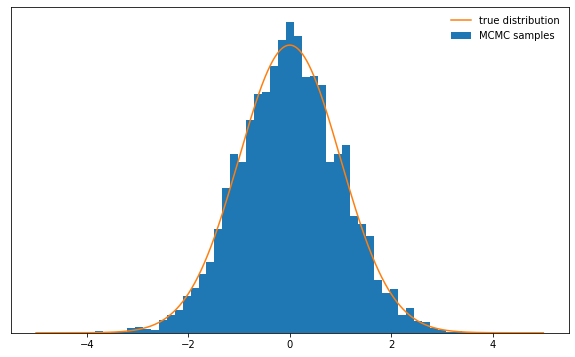

In [14]:
sample_and_display(np.array([2.0]), 3.0, 10000, 500, log_prob)

---------------

<h3><b>Ερωτήματα (Μέρος Β)</b></h3>

Να επαναλάβετε για $Δ=30$ και συνολικό αριθμό βημάτων $10000$. Τι παρατηρείτε ότι συμβαίνει στην περίπτωση που χρησιμοποιείτε ένα πολύ μεγάλο βήμα, δηλαδή πολύ μεγάλη τιμή για την παράμετρο $Δ$; Να επαναλάβετε για $Δ=300$, $Δ=3000$ και $Δ=30000$, ώστε να επιβεβαιώσετε το συμπέρασμά σας. Σχολιάστε και το ποσοστό των αποδεκτών βημάτων.

--------------

**Σημείωση**: σε όλα τα πειράματα αυτού του μέρους θέσαμε `n_burnin = 0` καθώς δεν εξετάζουμε αυτή τη λειτουργία εδώ.

 - $\Delta = 30$ και συνολικός αριθμός βημάτων: $10,000$

Acceptance rate: 0.111


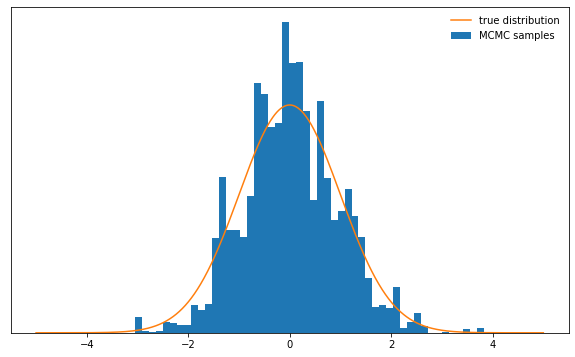

In [15]:
sample_and_display(np.array([2.0]), 30, 10000, 0, log_prob)

- $\Delta = 300$ και συνολικός αριθμός βημάτων: $10,000$

Acceptance rate: 0.011


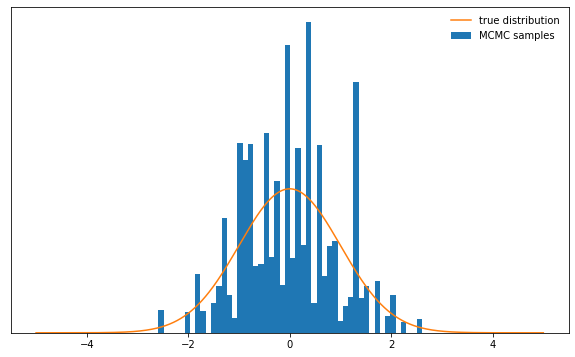

In [16]:
sample_and_display(np.array([2.0]), 300, 10000, 0, log_prob)

- $\Delta = 3000$ και συνολικός αριθμός βημάτων: $10,000$

Acceptance rate: 0.001


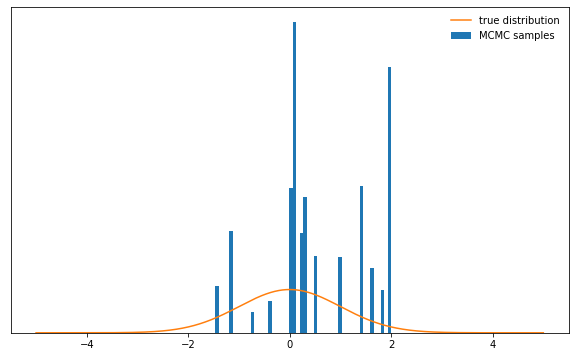

In [17]:
sample_and_display(np.array([2.0]), 3000, 10000, 0, log_prob)

- $\Delta = 30000$ και συνολικός αριθμός βημάτων: $10,000$

Acceptance rate: 0.000


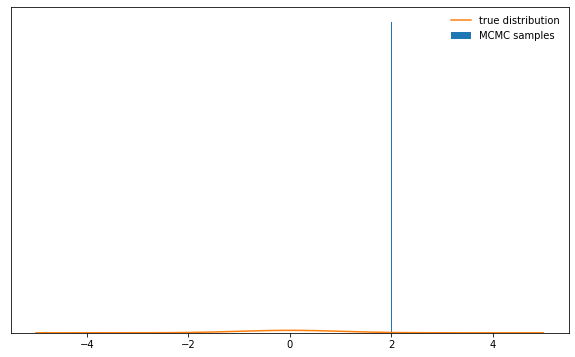

In [18]:
sample_and_display(np.array([2.0]), 30000, 10000, 0, log_prob)

Για συνολικό αριθμό βημάτων 10,000, έχουμε:
 - $\Delta = 30 \rightarrow acceptance \ ratio = 11.1\% $ 
 - $\Delta = 300 \rightarrow acceptance \ ratio = 1.1\% $ 
 - $\Delta = 3000 \rightarrow acceptance \ ratio = 0.1\% $ 
 - $\Delta = 30000 \rightarrow acceptance \ ratio = 0\% $ 

> Τι παρατηρείτε ότι συμβαίνει στην περίπτωση που χρησιμοποιείτε ένα πολύ μεγάλο βήμα, δηλαδή πολύ μεγάλη τιμή για την παράμετρο $Δ$;

Το `stepsize` δηλαδή η παράμετρος $\Delta$ της proposed κατανομής ελέγχει πόσο μεγάλο βήμα θα κάνει η αλυσίδα markov. Αν αυτό το βήμα είναι πολύ μεγάλο, τότε το δείγμα που επιλέγει ο αλγόριθμος μπορεί πολύ συχνά να βρίσκεται στις ουρές της κατανομής, εκεί η πυκνότητα είναι χαμηλότερη επομένως ένα τέτοιο δείγμα καταλήγει να απορρίπτεται από τον αλγόριθμο. 
Αυτό επιβεβαιώνεται καθώς βλέπουμε ότι όσο αυξάνουμε το βήμα το acceptance ratio μειώνεται μέχρι που φτάνει στο 0%. Άλλο ένα αποτέλεσμα είναι ότι η σύγκλιση είναι πιο αργή.

----------------------

Να επαναλάβετε για $Δ=0.1$, δηλαδή μία πολύ μικρή τιμή για το βήμα. Τι παρατηρείτε; Είναι ικανοποιητικά τα αποτελέσματά σας; Σχολιάστε και το ποσοστό των αποδεκτών βημάτων. Να επαναλάβετε για $Δ=0.01$.

- $\Delta = 0.1$ και συνολικός αριθμός βημάτων: $10,000$

Acceptance rate: 0.991


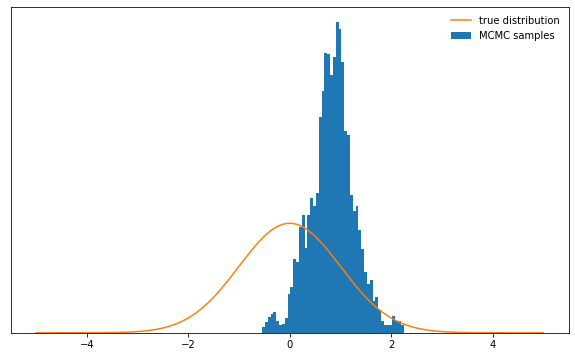

In [19]:
sample_and_display(np.array([2.0]), 0.1, 10000, 0, log_prob)

Να επαναλάβετε αυξάνοντας το συνολικό αριθμό βημάτων που θα πραγματοποιηθούν σε $500000$. Τι παρατηρείτε σχετικά με την ακρίβεια των αποτελεσμάτων σας, αλλά και το χρόνο εκτέλεσης του αλγορίθμου <b><i>Metropolis-Hastings</i></b>;

- $\Delta = 0.1$ και συνολικός αριθμός βημάτων: $500,000$

Acceptance rate: 0.990


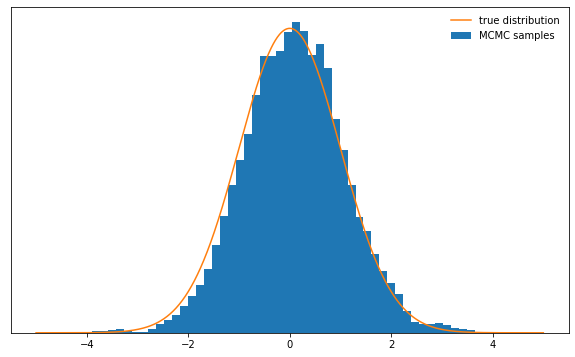

In [20]:
sample_and_display(np.array([2.0]), 0.1, 500000, 0, log_prob)

- $\Delta = 0.01$ και συνολικός αριθμός βημάτων: $10,000$

Acceptance rate: 0.997


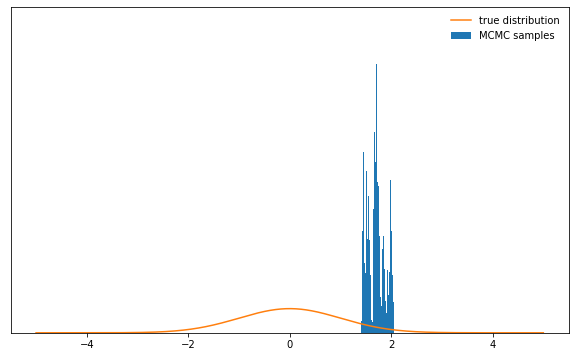

In [21]:
sample_and_display(np.array([2.0]), 0.01, 10000, 0, log_prob)

- $\Delta = 0.01$ και συνολικός αριθμός βημάτων: $500,000$

Acceptance rate: 0.999


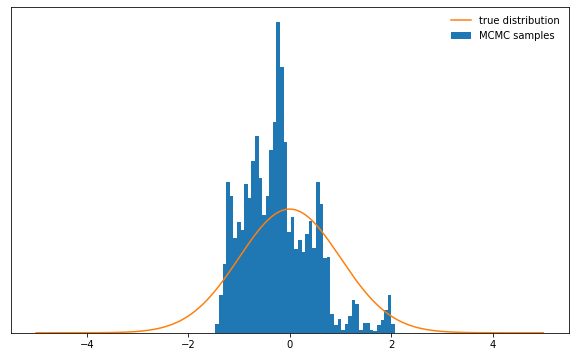

In [22]:
sample_and_display(np.array([2.0]), 0.01, 500000, 0, log_prob)

> Τι παρατηρείτε; Είναι ικανοποιητικά τα αποτελέσματά σας; Σχολιάστε και το ποσοστό των αποδεκτών βημάτων. 

Σχετικά με το προηγούμενο σχόλιο όπου αυξήσαμε το $\Delta$, θα αναμέναμε ότι η επιλογή ενός μικρού βήματος θα βελτιώσει την εικόνα του δείγματος. Η αλήθεια είναι ότι ακόμα κι αν ορίσουμε ένα πολύ μικρό βήμα, η αλυσίδα τελικά θα συγκλίνει όμως θα χρειαστεί πάρα πολλές (ενδεχομένως άπειρα αν είναι $\Delta \rightarrow 0$) επαναλήψεις.   
Έχουμε:   
- $\Delta=0.1$, βήματα: $10,000$ $\rightarrow$ $acceptance \ ratio: \ 99.1\%$  - όχι καλή σύγκλιση, δεν έχει εξερευνήσει ακόμα μακριά από την αρχική κατάσταση
- $\Delta=0.1$, βήματα: $500,000$ $\rightarrow$ $acceptance \ ratio: \ 99.0\%$ -  καλή σύγκλιση
- $\Delta=0.01$, βήματα: $10,000$ $\rightarrow$ $acceptance \ ratio: \ 99.7\%$ - όχι καλή σύγκλιση, πολύ κοντά στην αρχική κατάσταση
- $\Delta=0.01$, βήματα: $500,000$ $\rightarrow$ $acceptance \ ratio: \ 99.9\%$ - όχι καλή σύγκλιση, χρειάζεται ακόμα περισσότερα βήματα   
Η καλύτερη σύγκλιση επιτυγχάνεται για $\Delta=0.1$ σε $500,000$ βήματα, διότι το μικρό βήμα σε συνδιασμό με τον μεγάλο αριθμό επαναλήψεων είναι καλός συνδιασμός για να επιτύχουμε καλή σύγκλιση.
Το γεγονός ότι έχουμε acceptance ratio κοντά στη μονάδα δεν σημαίνει κάτι στην προκειμένη περίπτωση διότι η αλυσίδα συγκλίνει πολύ αργά. Τυπικά κάποιος ρυθμίζει τις παραμέτρους του βήματος και του αριθμού των επαναλήψεων έτσι ώστε ο αλγόριθμος να αποδέχεται ποσοστό των δειγμάτων της τάξης του 30% ([πηγή: Wikipedia](https://en.wikipedia.org/wiki/Metropolis%E2%80%93Hastings_algorithm#Step-by-step_instructions)).   
Όπως είναι αναμενόμενο, όσο αυξάνουμε τον αριθμό των επαναλήψεων αυξάνεται ο χρόνος εκτέλεσης, στις 500,000 επαναλήψεις παίρνει περίπου 12 δευτερόλεπτα η εκτέλεση. Επομένως αν θέλουμε καλό αποτέλεσμα σε λιγότερο χρόνο θα πρέπει να αυξήσουμε το Δ και να ελαττώσουμε τον αριθμό επαναλήψεων ώστε ο αλγόριθμος να συγκλίνει ταχύτερα.

-----------------

Η συνάρτηση <b><i>sample_and_display</i></b> περιλαμβάνει το n_burnin ως τέταρτο όρισμα. Ποια είναι η χρησιμότητα του ορίσματος αυτού; Δοκιμάστε τις παρακάτω τιμές:
<ul>
<li>$Δ=0.1$, αριθμός βημάτων $1000$ και n_burnin=$10$.</li>
<li>$Δ=0.1$, αριθμός βημάτων $500000$ και n_burnin=$490000$.</li>
</ul>
Τι παρατηρείτε; 

------------

- $Δ=0.1$, αριθμός βημάτων $1000$ και n_burnin=$10$

Acceptance rate: 0.979


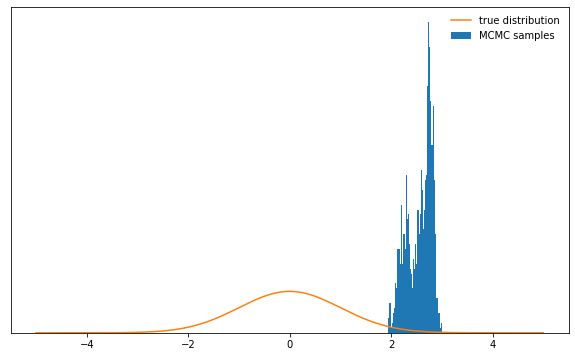

In [23]:
sample_and_display(np.array([2.0]), 0.1, 1000, 10, log_prob)

- $Δ=0.1$, αριθμός βημάτων $500000$ και n_burnin=$490000$.

Acceptance rate: 0.990


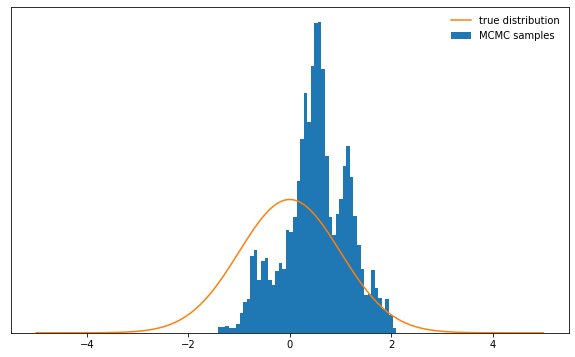

In [24]:
sample_and_display(np.array([2.0]), 0.1, 500000, 490000, log_prob)

 > Ποια είναι η χρησιμότητα του ορίσματος `n_burnin`;

Ο αλγόριθμος Metropolis Hastings έχει ως σκοπό τη δειγματοληψία από μια κατανομή $\pi(x)$ της οποίας, όπως είπαμε, δεν γνωρίζουμε την ακριβής μορφή. Αυτό σημαίνει ότι κατά την αρχικοποίηση του αλγορίθμου, μη έχοντας γνώση για την $\pi(x)$, μπορεί να επηρεάσουμε τα τελικά αποτελέσματα ακόμα και αν στην πορεία ο αλγόριθμος συγκλίνει σε αυτή. Για να αποζημιώσουμε για αυτό το γεγονός εφαρμόζουμε μια burn-in περίοδο όπου «πετάμε» τα πρώτα $N$ δείγματα, με το $N$ να εκλέγεται αρκετά μεγάλο ώστε η αλυσίδα να έχει φτάσει σε σημείο που δειγματοληπτεί ικανοποιητικά την $\pi(x)$. Έτσι, η παράμετρος `n_burnin` ρυθμίζει πόσα από τα αρχικά δείγματα θα αγνοήσουμε.  
Συνοψίζοντας τα αποτελέσματα:   
- $Δ=0.1$, αριθμός βημάτων $1000$ και n_burnin=$10$: $acceptance \ ratio: \ 97.9\%$.
Εδώ έχουμε μικρό Δ επομένως έτσι εξηγείται το μεγάλο acceptance ratio. Δεν έχουμε καλή σύγκλιση αλλά αυτό οφείλεται στον συνδιασμό Δ και αριθμού επαναλήψεων, καθώς δεν είναι αρκετές οι επαναλήψεις για να συγκλίνει. Σε κάθε περίπτωση, η απόρριψη 10 δειγμάτων δεν έχει μεγάλη επίπτωση στο αποτέλεσμα.
- $Δ=0.1$, αριθμός βημάτων $500000$ και n_burnin=$490000$: $acceptance \ ratio: \ 98.9\%$. 
Παραπάνω είδαμε ότι με αυτές τις παραμέτρους επιτυγχάνεται πολύ καλή σύγκλιση. Εδώ, θα ίσχυε κάτι τέτοιο, όμως ο πολύ μεγάλος αριθμός των παραμέτρων που απορρίπτουμε σαν αρχική burn-in περίοδο, σβήνει τα περισσότερα δείγματα επομένως σε συνδιασμό με το μικρό Δ, δεν είναι αρκετά τα δείγματα που απέμειναν για να περιγράψουν ικανοποιητικά την κατανομή. Γενικά, συνηθίζεται ως burn-in περίοδος να θεωρούνται οι πρώτες μερικές εκατοντάδες ή χιλιάδες επαναλήψεις, ενώ εδώ οι 490,000 τιμές που απορρίπτονται αποτελούν το 98\% των συνολικών δειγμάτων.